# Chapter 4: Relationship between Runs Scored and Wins

In [65]:
# this is where all my libraries will be stored

library('tidyverse')
library(Lahman)
library(broom)
library(ggrepel)
library(skimr)

# We will be creating an analyzing a Linear Model to assess the impact and or magnitude that Runs have on the number of games that you will win in a season

## First, lets take the Lahman dataset and get the team information on all MLB teams from 2013 going forward

In [36]:
# get win pct for all years preceeding 2000 except 2020 season
Teams %>%
  filter(yearID >= 2000 & yearID != 2020) %>%
  select(teamID, yearID, G, W, L,R,RA) -> Teams_2000_beyond


View(head(Teams_2000_beyond, 5))

,teamID,yearID,G,W,L,R,RA
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
1,ANA,2000,162,82,80,864,869
2,ARI,2000,162,85,77,792,754
3,ATL,2000,162,95,67,810,714
4,BAL,2000,162,74,88,794,913
5,BOS,2000,162,85,77,792,745


## Next, lets get the Win Pct and the Run Differentials for every team

In [37]:


Teams_2000_beyond  %>%
  mutate(Run_diff = R- RA, Win_Pct = W/G) -> Teams_2000_beyond


View(head(Teams_2000_beyond, 5))

,teamID,yearID,G,W,L,R,RA,Run_diff,Win_Pct
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,ANA,2000,162,82,80,864,869,-5,0.5061728
2,ARI,2000,162,85,77,792,754,38,0.5246914
3,ATL,2000,162,95,67,810,714,96,0.5864198
4,BAL,2000,162,74,88,794,913,-119,0.4567901
5,BOS,2000,162,85,77,792,745,47,0.5246914


## Ok, now lets plot this and see if there is a linear relationship

`geom_smooth()` using formula = 'y ~ x'


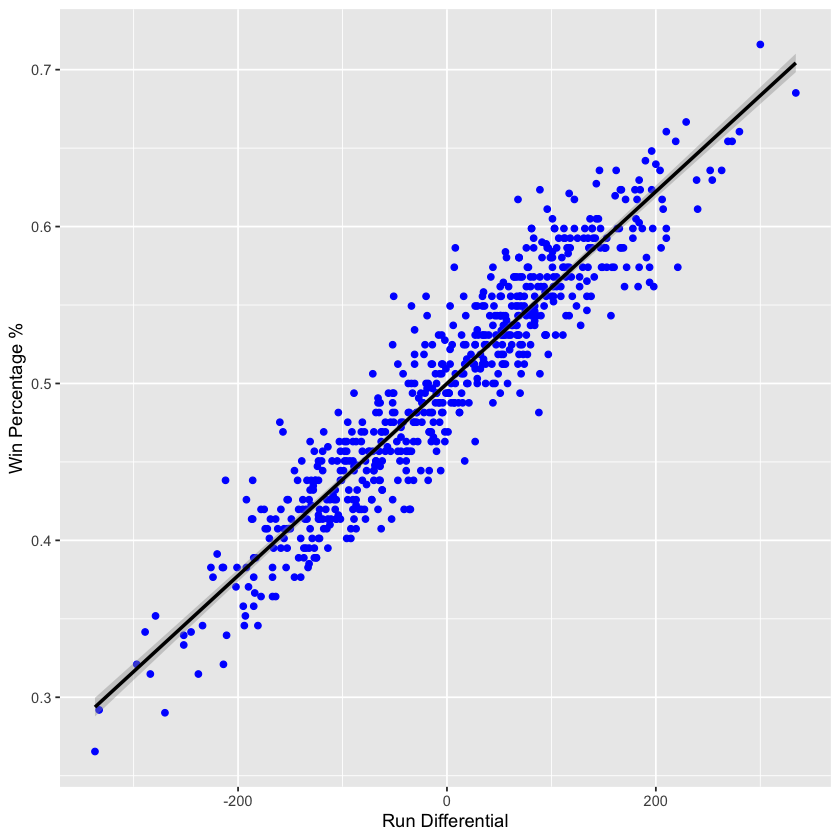

In [38]:

ggplot(data=Teams_2000_beyond, aes(x=Run_diff, y=Win_Pct))+
geom_point(color='blue')+
  geom_smooth(method="lm", color='black')+
labs(x='Run Differential', y='Win Percentage %')

## Also lets see the distribution of the dataset to see if this is normally distributed

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


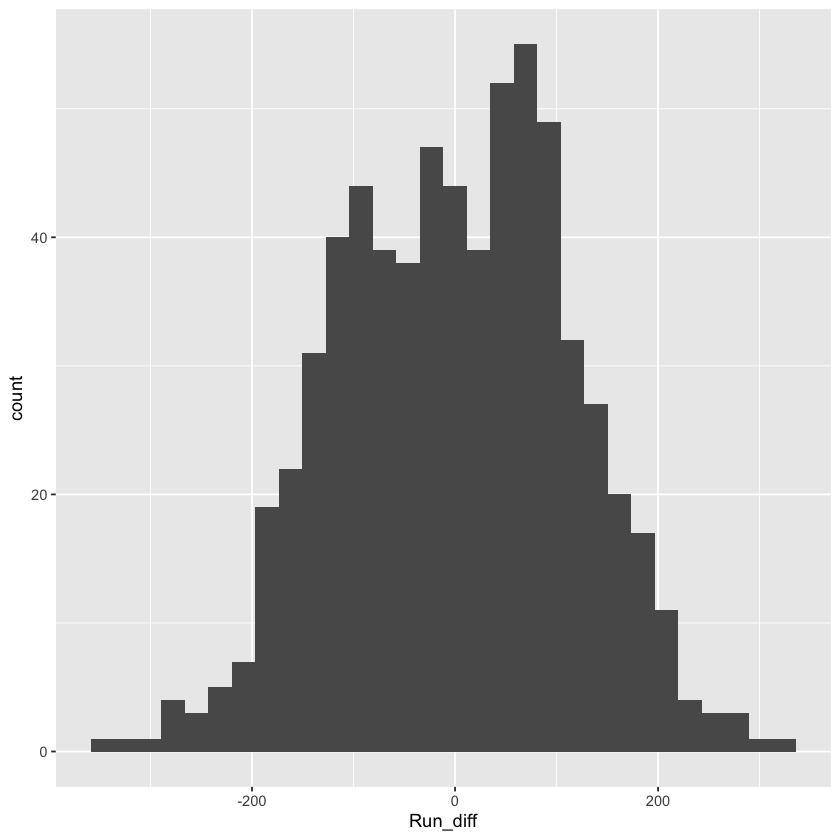

In [39]:
ggplot(data=Teams_2000_beyond, aes(x=Run_diff)) +
geom_histogram() 

## looks normally distributed

## As seen above, the Run differential and Win Percentage have a positive linear relationship between the two, ow less get the linear formula

In [40]:
# this creates a linear model with Response ~ predictors 
linfit <- lm(Win_Pct ~ Run_diff, data=Teams_2000_beyond)

linfit


Call:
lm(formula = Win_Pct ~ Run_diff, data = Teams_2000_beyond)

Coefficients:
(Intercept)     Run_diff  
  0.4999306    0.0006119  


## From this, you can see that a rough estimate for the linear model would be: y = .4999306 + .0006119x with y being win percentage and x being the run differential, which would suggest that a team with a 0 run differential should be expected to have about a 50% win percentage or win 81 games in a full 162 game season.

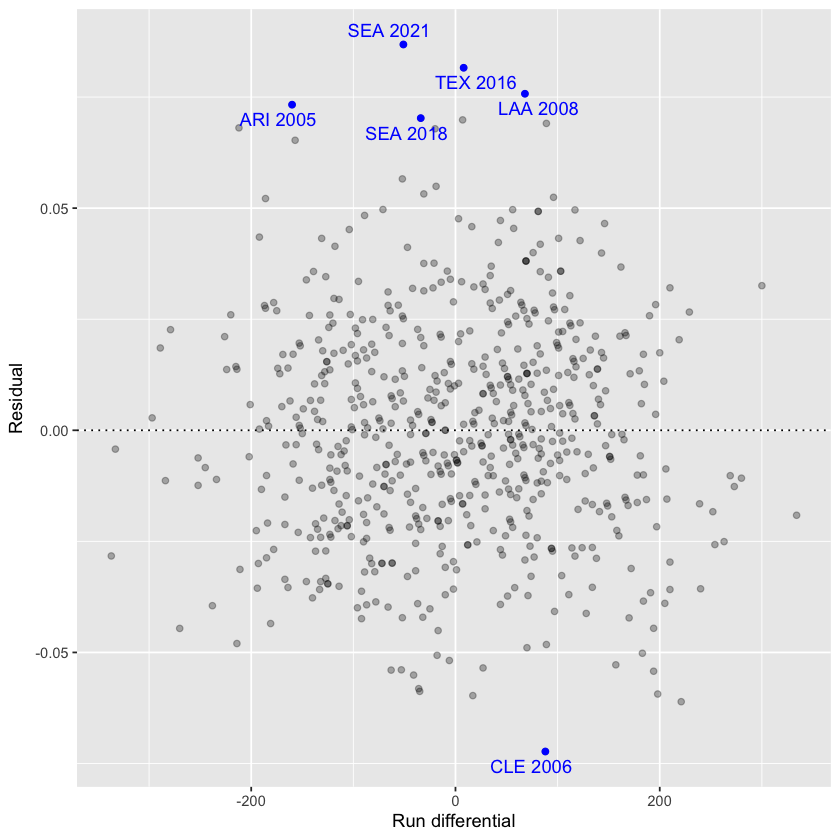

In [41]:
# this calculates residuals and other measures based on the linear model
my_teams_aug <- augment(linfit, data=Teams_2000_beyond)



# this plots all the residuals to get an idea of the distributed differences
base_plot <- ggplot(data=my_teams_aug, aes(x=Run_diff, y=.resid)) +
  geom_point(alpha = .3) +
  geom_hline(yintercept = 0, linetype=3) +
  xlab("Run differential" ) + ylab("Residual")
# this picks the highest residuals and selects those 6 points
highlight_teams <- my_teams_aug %>%
  arrange(desc(abs(.resid))) %>%
  head(6)


text_plot <- base_plot +
  geom_point(data=highlight_teams, color='blue') +
  geom_text_repel(data=highlight_teams, color='blue', aes(label=paste(teamID, yearID)))

text_plot

## Now we will evaluate this model by taking the Root Mean Squared Error

In [42]:
my_teams_aug %>%
summarize(N = n(),
          avg=  mean(.resid),
          rmse = sqrt(mean(.resid^2))
) -> rmse_result


rmse_result


rmse <- rmse_result %>%
pull(rmse)

N,avg,rmse
<int>,<dbl>,<dbl>
660,1.132893e-16,0.02498528


## Referencing the empirical rule, approximately  68% of the residuals should be within - rmse and 95% within -2 * rmse and 2 rmse and 99% between -3 rmse and 3 rmse, so lets test that to fully confirm the dataset is normally distributed like earlier in this document [Empirical Rule Wiki](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule)

In [43]:
my_teams_aug %>%
summarize(
  N = n(),
  within_one = sum(abs(.resid) < rmse),
  within_two = sum(abs(.resid)< 2*rmse),
  within_three = sum(abs(.resid)< 3*rmse)
) -> summary

summary %>%
  mutate(
    within_one_percentage = within_one / N,
    within_two_percentage = within_two / N,
    within_three_percentage = within_three / N,
    
  ) -> summary


summary

N,within_one,within_two,within_three,within_one_percentage,within_two_percentage,within_three_percentage
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
660,452,630,657,0.6848485,0.9545455,0.9954545


## From looking at the above numbers we can see that it matches the empirical rule and the residuals are confirmed normally distributed as well

# Pythagorean Formula for Win Percentage (Non-linear Formula)


## W pct = R^2 / (R^2 + RA^2)
### R --> Runs RA --> Runs Allowed

In [97]:
Teams_2000_beyond %>%
mutate(Win_Pct_Pythag = R^2 / (RA^2+ R^2)) -> Teams_2000_beyond 


Teams_2000_beyond %>%
  mutate(residuals_pythag = Win_Pct - Win_Pct_Pythag) -> Teams_2000_beyond


head(Teams_2000_beyond,5)

,teamID,yearID,G,W,L,R,RA,Run_diff,Win_Pct,Win_Pct_Pythag,residuals_pythag,log_w_ratio,logR_ratio
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ANA,2000,162,82,80,864,869,-5,0.5061728,0.4971149,0.0090579857,0.02469261,-0.005770356
2,ARI,2000,162,85,77,792,754,38,0.5246914,0.5245647,0.0001266388,0.09884583,0.049169024
3,ATL,2000,162,95,67,810,714,96,0.5864198,0.5627432,0.0236765925,0.34918427,0.126151285
4,BAL,2000,162,74,88,794,913,-119,0.4567901,0.4306242,0.0261659111,-0.17327172,-0.139652419
5,BOS,2000,162,85,77,792,745,47,0.5246914,0.5305505,-0.0058591250,0.09884583,0.061177173


In [98]:



Teams_2000_beyond %>%
  summarize(
    rmse = sqrt(mean(residuals_pythag^2))
  ) -> pythag_summary


pythag_summary

rmse
<dbl>
0.02585413


## This value is similar to the rmse of the linear model, but it provides a more accurate predictor  for extreme cases than in the linear cases

## Refinements in the formula allow for us to asses the usecases of different exponents besides 2, we could rewrite the formula as this:
## W% = W /(W+L) = R^(k) / R^(k) + RA^(k)


## With algebra, this can be rewritten as W/L = R^(k) / (RA)^(k)


## Then taking the logarithm on both sides one obtains the linear relationship
## log (W/L) = k * log (R/RA)

## the value of k can now be estimated using linear regression where log(W/L) is the response and log(R/RA) is the predictor

In [99]:
Teams_2000_beyond %>%
  mutate(log_w_ratio = log(W/L),
         logR_ratio = log(R/RA)) -> Teams_2000_beyond


pythag_log_lin_fit <- lm(log_w_ratio ~ 0+ logR_ratio, data=Teams_2000_beyond)


pythag_log_lin_fit


Call:
lm(formula = log_w_ratio ~ 0 + logR_ratio, data = Teams_2000_beyond)

Coefficients:
logR_ratio  
     1.833  


## This suggests that a best fit k value for the exponent is 1.833

# Good and bad predictions using the Pythagorean Model

## Using the 2 exponent Pythag model the 2011 Boston Red Sox scored 875 runs and allowed 737 runs Plugging it into that formula, they were predicted to win 95 games, but they only won 90, which kept them out of the wildcard that year. But it works well with the Tampa Bay Rays with a prediction of 92 when they actually won 91

In [100]:
# bring in 2011 season data from retrosheets
season_headers <- read_csv('datasets/game_log_header.csv')
season_data_2021_gbg <- read_csv('datasets/gl2011.txt',
                                 col_names = names(season_headers),
na = character())


head(season_data_2021_gbg,5)

Rows: 0 Columns: 161
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (161): Date, DoubleHeader, DayOfWeek, VisitingTeam, VisitingTeamLeague, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 2429 Columns: 161
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (73): DayOfWeek, VisitingTeam, VisitingTeamLeague, HomeTeam, HomeTeamLea...
dbl (83): Date, DoubleHeader, VisitingTeamGameNumber, HomeTeamGameNumber, Vi...
num  (1): CompletionInfo
lgl  (4): ForfeitInfo, ProtestInfo, Umpi

Date,DoubleHeader,DayOfWeek,VisitingTeam,VisitingTeamLeague,VisitingTeamGameNumber,HomeTeam,HomeTeamLeague,HomeTeamGameNumber,VisitorRunsScored,⋯,HomeBatting7Name,HomeBatting7Position,HomeBatting8PlayerID,HomeBatting8Name,HomeBatting8Position,HomeBatting9PlayerID,HomeBatting9Name,HomeBatting9Position,AdditionalInfo,AcquisitionInfo
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,⋯,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
20110331,0,Thu,MIL,NL,1,CIN,NL,1,6,⋯,Ramon Hernandez,2,janip001,Paul Janish,6,volqe001,Edinson Volquez,1,,Y
20110331,0,Thu,SFN,NL,1,LAN,NL,1,1,⋯,Rod Barajas,2,carrj001,Jamey Carroll,4,kersc001,Clayton Kershaw,1,,Y
20110331,0,Thu,SDN,NL,1,SLN,NL,1,5,⋯,Yadier Molina,2,schus001,Skip Schumaker,4,carpc002,Chris Carpenter,1,,Y
20110331,0,Thu,ATL,NL,1,WAS,NL,1,2,⋯,Danny Espinosa,4,rodri001,Ivan Rodriguez,2,hernl003,Livan Hernandez,1,,Y
20110331,0,Thu,ANA,AL,1,KCA,AL,1,4,⋯,Alcides Escobar,6,tream001,Matt Treanor,2,getzc001,Chris Getz,4,,Y


## Now lets specifically get only games in which boston played

In [101]:
season_data_2021_gbg %>%
  filter(HomeTeam == "BOS" | VisitingTeam == "BOS") %>%
  select(VisitingTeam, HomeTeam, VisitorRunsScored, HomeRunsScore) -> Boston_2011


head(Boston_2011,5)

VisitingTeam,HomeTeam,VisitorRunsScored,HomeRunsScore
<chr>,<chr>,<dbl>,<dbl>
BOS,TEX,5,9
BOS,TEX,5,12
BOS,TEX,1,5
BOS,CLE,1,3
BOS,CLE,4,8


## Now we will add a column for individual run differentials and whether or not they won the game or not

In [102]:
Boston_2011 %>%
mutate(ScoreDiff = ifelse(HomeTeam == "BOS", HomeRunsScore -VisitorRunsScored, VisitorRunsScored - HomeRunsScore ),
       W = ScoreDiff > 0) -> Boston_2011


head(Boston_2011,5)

VisitingTeam,HomeTeam,VisitorRunsScored,HomeRunsScore,ScoreDiff,W
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
BOS,TEX,5,9,-4,FALSE
BOS,TEX,5,12,-7,FALSE
BOS,TEX,1,5,-4,FALSE
BOS,CLE,1,3,-2,FALSE
BOS,CLE,4,8,-4,FALSE


In [103]:
Boston_2011 %>%
group_by(W) %>%
skim(ScoreDiff)

── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             162       
Number of columns          6         
_______________________              
Column type frequency:               
  numeric                  1         
________________________             
Group variables            W         

── Variable type: numeric ──────────────────────────────────────────────────────
  skim_variable W     n_missing complete_rate  mean   sd  p0 p25 p50 p75 p100
1 ScoreDiff     FALSE         0             1 -3.46 2.56 -11  -4  -3  -1   -1
2 ScoreDiff     TRUE          0             1  4.3  3.28   1   2   4   6   14
  hist 
1 ▁▂▂▆▇
2 ▇▆▁▁▁


ERROR: Error in is.null(text_repr) || nchar(text_repr) == 0L: 'length = 13' in coercion to 'logical(1)'


## From looking at this we can see that their margins of victory were on average decided by more runs than their losses, so they could have lost more games than expected from run differentials due to losing more close games

In [104]:
results <- season_data_2021_gbg %>%
        select(VisitingTeam, HomeTeam, VisitorRunsScored, HomeRunsScore) %>%
        mutate(winner = ifelse(HomeRunsScore > VisitorRunsScored, HomeTeam, VisitingTeam),
               diff = abs(VisitorRunsScored - HomeRunsScore))


head(results,5)

VisitingTeam,HomeTeam,VisitorRunsScored,HomeRunsScore,winner,diff
<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
MIL,CIN,6,7,CIN,1
SFN,LAN,1,2,LAN,1
SDN,SLN,5,3,SDN,2
ATL,WAS,2,0,ATL,2
ANA,KCA,4,2,ANA,2


## Now, we will get a df of the number of one win games by team

In [105]:
results %>%
  filter(diff == 1) %>%
  group_by(winner) %>%
  summarize(one_run_wins = n()) -> one_win_games_by_team_2011



head(one_win_games_by_team_2011,5)

winner,one_run_wins
<chr>,<int>
ANA,27
ARI,28
ATL,29
BAL,22
BOS,19


## Now we will use the df earlier to join the df hwere so we can make a plot of the one run wins compared to the pytag residuals

In [106]:
teams_2011 <- Teams_2000_beyond %>%
        filter(yearID == 2011) %>%
        mutate(teamID = ifelse(teamID == "LAA", "ANA", as.character(teamID))) %>%
        inner_join(one_win_games_by_team_2011, by = c("teamID" = "winner"))


head(teams_2011, 5)

,teamID,yearID,G,W,L,R,RA,Run_diff,Win_Pct,Win_Pct_Pythag,residuals_pythag,log_w_ratio,logR_ratio,one_run_wins
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,ARI,2011,162,94,68,731,662,69,0.5802469,0.5494121,0.03083477,0.32378708,0.09914790,28
2,ATL,2011,162,89,73,641,605,36,0.5493827,0.5288684,0.02051436,0.19817693,0.05780100,29
3,BAL,2011,162,69,93,708,860,-152,0.4259259,0.4039637,0.02196224,-0.29849299,-0.19448830,22
4,BOS,2011,162,90,72,875,737,138,0.5555556,0.5849851,-0.02942955,0.22314355,0.17163599,19
5,CHA,2011,162,79,83,654,706,-52,0.4876543,0.4618205,0.02583380,-0.04939276,-0.07650789,24


## Now to plot the residuals to one run wins

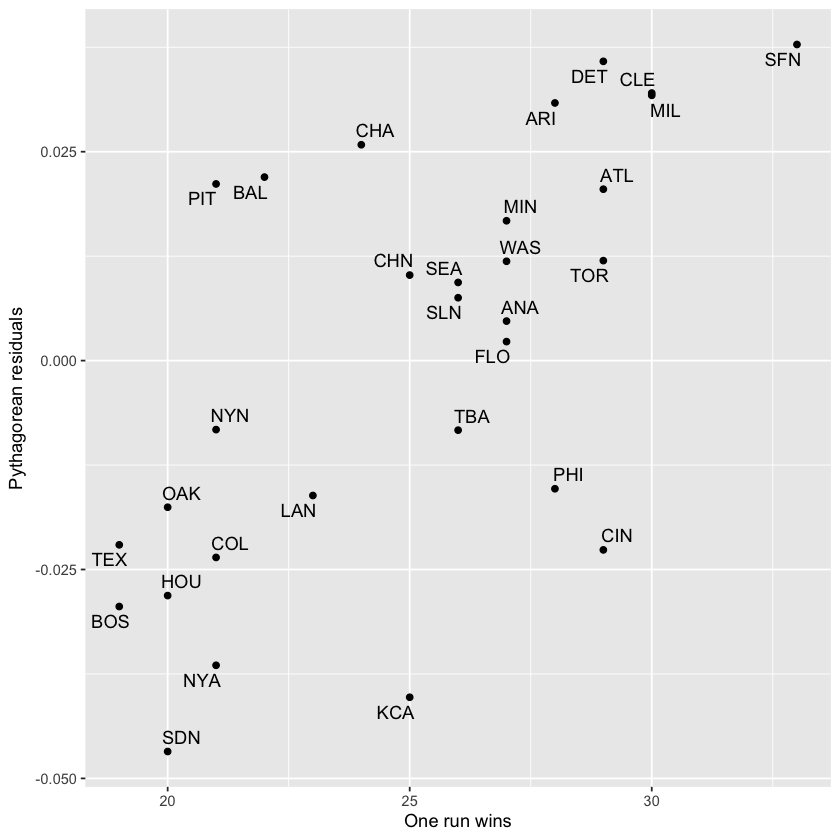

In [107]:
ggplot(data = teams_2011, aes(x=one_run_wins, y=residuals_pythag)) +
geom_point() +
geom_text_repel(aes(label=teamID)) +
xlab("One run wins") +
ylab("Pythagorean residuals")

## From this we can see that Boston lost a disproportion amount of one run games, while San fran won a disproportion amount of one run games, some of the disproportionate amount of one run wins could be attributed to luck and some could be attributed to having top level closers, lets take a closer look at closers now

In [109]:
Pitching %>%
filter(yearID == 2011, GF>50) %>%
summarize(Avg_era = mean(ERA)) -> avg_2011_era



avg_era <- avg_2011_era %>%
        pull(Avg_era)

avg_era

[1] 2.6175

In [111]:
top_closers <- Pitching %>%
        filter(GF > 50 & ERA < avg_era) %>%
        select(playerID, yearID, teamID)

Teams_2000_beyond %>%
        inner_join(top_closers) %>%
        pull(residuals_pythag) %>%
        summary()

Joining with `by = join_by(teamID, yearID)`


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.048693 -0.011543  0.002303  0.004701  0.020377  0.081164 

# How many Runs for a Win?